Final workflow k-means - VALIDATED:
- Clusters assigned to each sequence for 3 and 4 clusters
- Majority-vote mapping of clusters → morphotype
- Predicted morphotypes for each sequence based on cluster
- Classification reports showing precision, recall, f1-score
- Excel file with all info saved

In [ ]:
%pip install torch torchvision torchaudio
%pip install fair-esm
%pip install umap-learn seaborn pandas openpyxl


Finding optimal number of clusters...
Silhouette score for k=2: 0.0092
Silhouette score for k=3: 0.0069
Silhouette score for k=4: 0.0102
Silhouette score for k=5: 0.0170
Silhouette score for k=6: 0.0289
Silhouette score for k=7: 0.0321
Silhouette score for k=8: 0.0324
Silhouette score for k=9: 0.0338

Best number of clusters: 9 (score=0.0338)

Cluster to Morphotype Mapping:
{np.int32(6): 'Myoviridae', np.int32(4): 'Podoviridae', np.int32(8): 'Podoviridae', np.int32(5): 'Podoviridae', np.int32(3): 'Podoviridae', np.int32(1): 'Podoviridae', np.int32(2): 'Podoviridae', np.int32(0): 'Myoviridae', np.int32(7): 'Siphoviridae'}

Classification Report:
              precision    recall  f1-score   support

  Myoviridae       0.42      0.53      0.47        15
 Podoviridae       0.56      0.80      0.66        25
Siphoviridae       1.00      0.17      0.29        18

    accuracy                           0.53        58
   macro avg       0.66      0.50      0.47        58
weighted avg       0

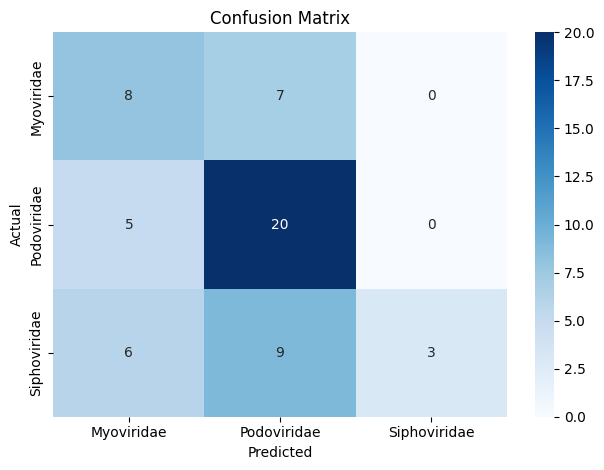


Saved results to 'phage_clustered_with_morphotypes.xlsx'


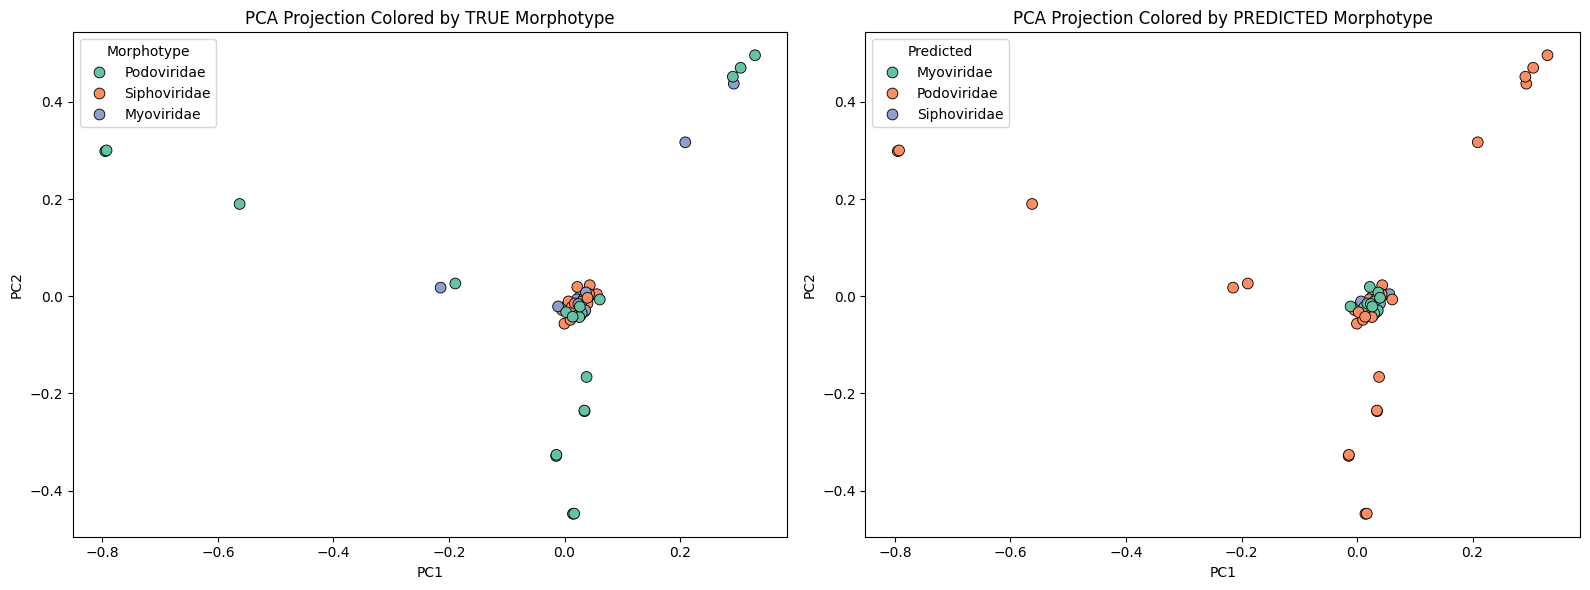

C:\Users\catia\AppData\Local\Temp\ipykernel_20944\608211872.py:109: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


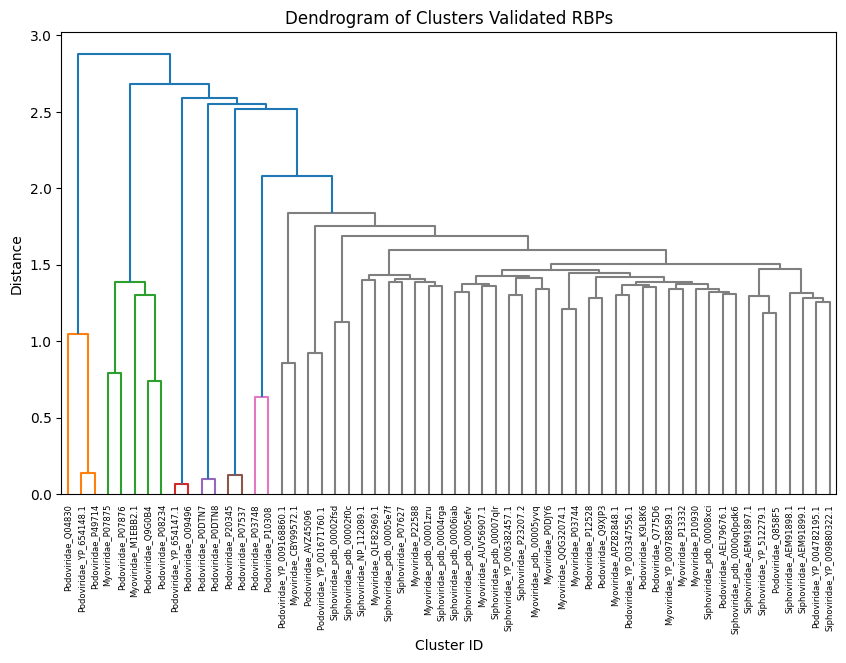

In [23]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Data ===
df = pd.read_excel("validated_processed.xlsx")
sequences = df["CleanSeq"].astype(str).tolist()

# === Vectorize Sequences with TF-IDF 3–4-mers ===
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 4))
X = vectorizer.fit_transform(sequences)

# === Find Optimal K Using Silhouette Score ===
best_k = None
best_score = -1
score_dict = {}

print("\nFinding optimal number of clusters...")
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    score_dict[k] = score
    print(f"Silhouette score for k={k}: {score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nBest number of clusters: {best_k} (score={best_score:.4f})")

# === Final KMeans with Best K ===
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
df["BestKMeans_Cluster"] = kmeans.fit_predict(X)

# === Majority Vote Mapping from Cluster to Morphotype ===
def assign_morphotypes_by_majority(df, cluster_col, morph_col):
    mapping = {}
    for cluster in df[cluster_col].unique():
        subset = df[df[cluster_col] == cluster]
        most_common = subset[morph_col].mode()
        if not most_common.empty:
            mapping[cluster] = most_common.iloc[0]
        else:
            mapping[cluster] = "Unknown"
    return mapping

def apply_cluster_to_morphotype_mapping(df, cluster_col, mapping):
    return df[cluster_col].map(mapping).fillna("Unknown")

cluster_to_morph = assign_morphotypes_by_majority(df, "BestKMeans_Cluster", "Morphotype")
df["Predicted_morphotype"] = apply_cluster_to_morphotype_mapping(df, "BestKMeans_Cluster", cluster_to_morph)

print(f"\nCluster to Morphotype Mapping:\n{cluster_to_morph}")

# === Evaluate ===
valid_rows = df["Predicted_morphotype"].notna()
print("\nClassification Report:")
print(classification_report(df.loc[valid_rows, "Morphotype"], df.loc[valid_rows, "Predicted_morphotype"], zero_division=0))

# === Confusion Matrix ===
conf_mat = pd.crosstab(df["Morphotype"], df["Predicted_morphotype"], rownames=["Actual"], colnames=["Predicted"])
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === Save Results ===
df.to_excel("phage_clustered_with_morphotypes.xlsx", index=False)
print("\nSaved results to 'phage_clustered_with_morphotypes.xlsx'")

# === PCA Visualization ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Add coordinates to dataframe
df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

# === Plot PCA Results ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot by True Morphotype
sns.scatterplot(data=df, x="PC1", y="PC2", hue="Morphotype", palette="Set2",
                s=60, edgecolor='k', ax=axes[0])
axes[0].set_title("PCA Projection Colored by TRUE Morphotype")
axes[0].legend(title="Morphotype", loc='best')

# Plot by Predicted Morphotype
sns.scatterplot(data=df, x="PC1", y="PC2", hue="Predicted_morphotype", palette="Set2",
                s=60, edgecolor='k', ax=axes[1])
axes[1].set_title("PCA Projection Colored by PREDICTED Morphotype")
axes[1].legend(title="Predicted", loc='best')

plt.tight_layout()
plt.show()

# === Dendrogram Visualization ===
# Compute the distance matrix
distance_matrix = pairwise_distances(X.toarray(), metric='cosine')

# Create the linkage matrix
Z = linkage(distance_matrix, method='ward')

# Plotting the dendrogram
plt.figure(figsize=(10, 6))
labels = df.apply(lambda row: f"{row['Morphotype']}_{row['RBP Accession']}", axis=1).values
dendrogram(Z, labels=labels)
plt.title('Dendrogram of Clusters Validated RBPs')
plt.xlabel('Cluster ID')
plt.ylabel('Distance')
plt.show()


In [14]:
print(df["Morphotype"].value_counts())
print(df["Predicted_morphotype"].value_counts())


Morphotype
Podoviridae     25
Siphoviridae    18
Myoviridae      15
Name: count, dtype: int64
Predicted_morphotype
Podoviridae     36
Myoviridae      19
Siphoviridae     3
Name: count, dtype: int64


-----------------------------------------------------------------------------------

Final workflow k-means - VALIDATED AND NONVALIDATED:
- Clusters assigned to each sequence for 3 and 4 clusters
- Majority-vote mapping of clusters → morphotype
- Predicted morphotypes for each sequence based on cluster
- Classification reports showing precision, recall, f1-score
- Excel file with all info saved

Finding best k based on silhouette score...
k=2, silhouette score=0.0140
k=3, silhouette score=0.0233
k=4, silhouette score=0.0301
Best k = 4 with silhouette score = 0.0301


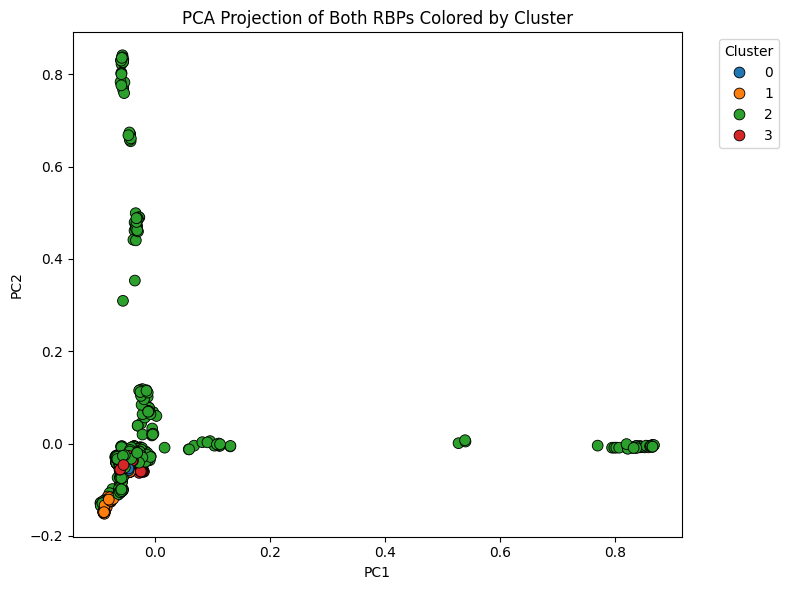

C:\Users\catia\AppData\Local\Temp\ipykernel_20944\3201243672.py:53: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


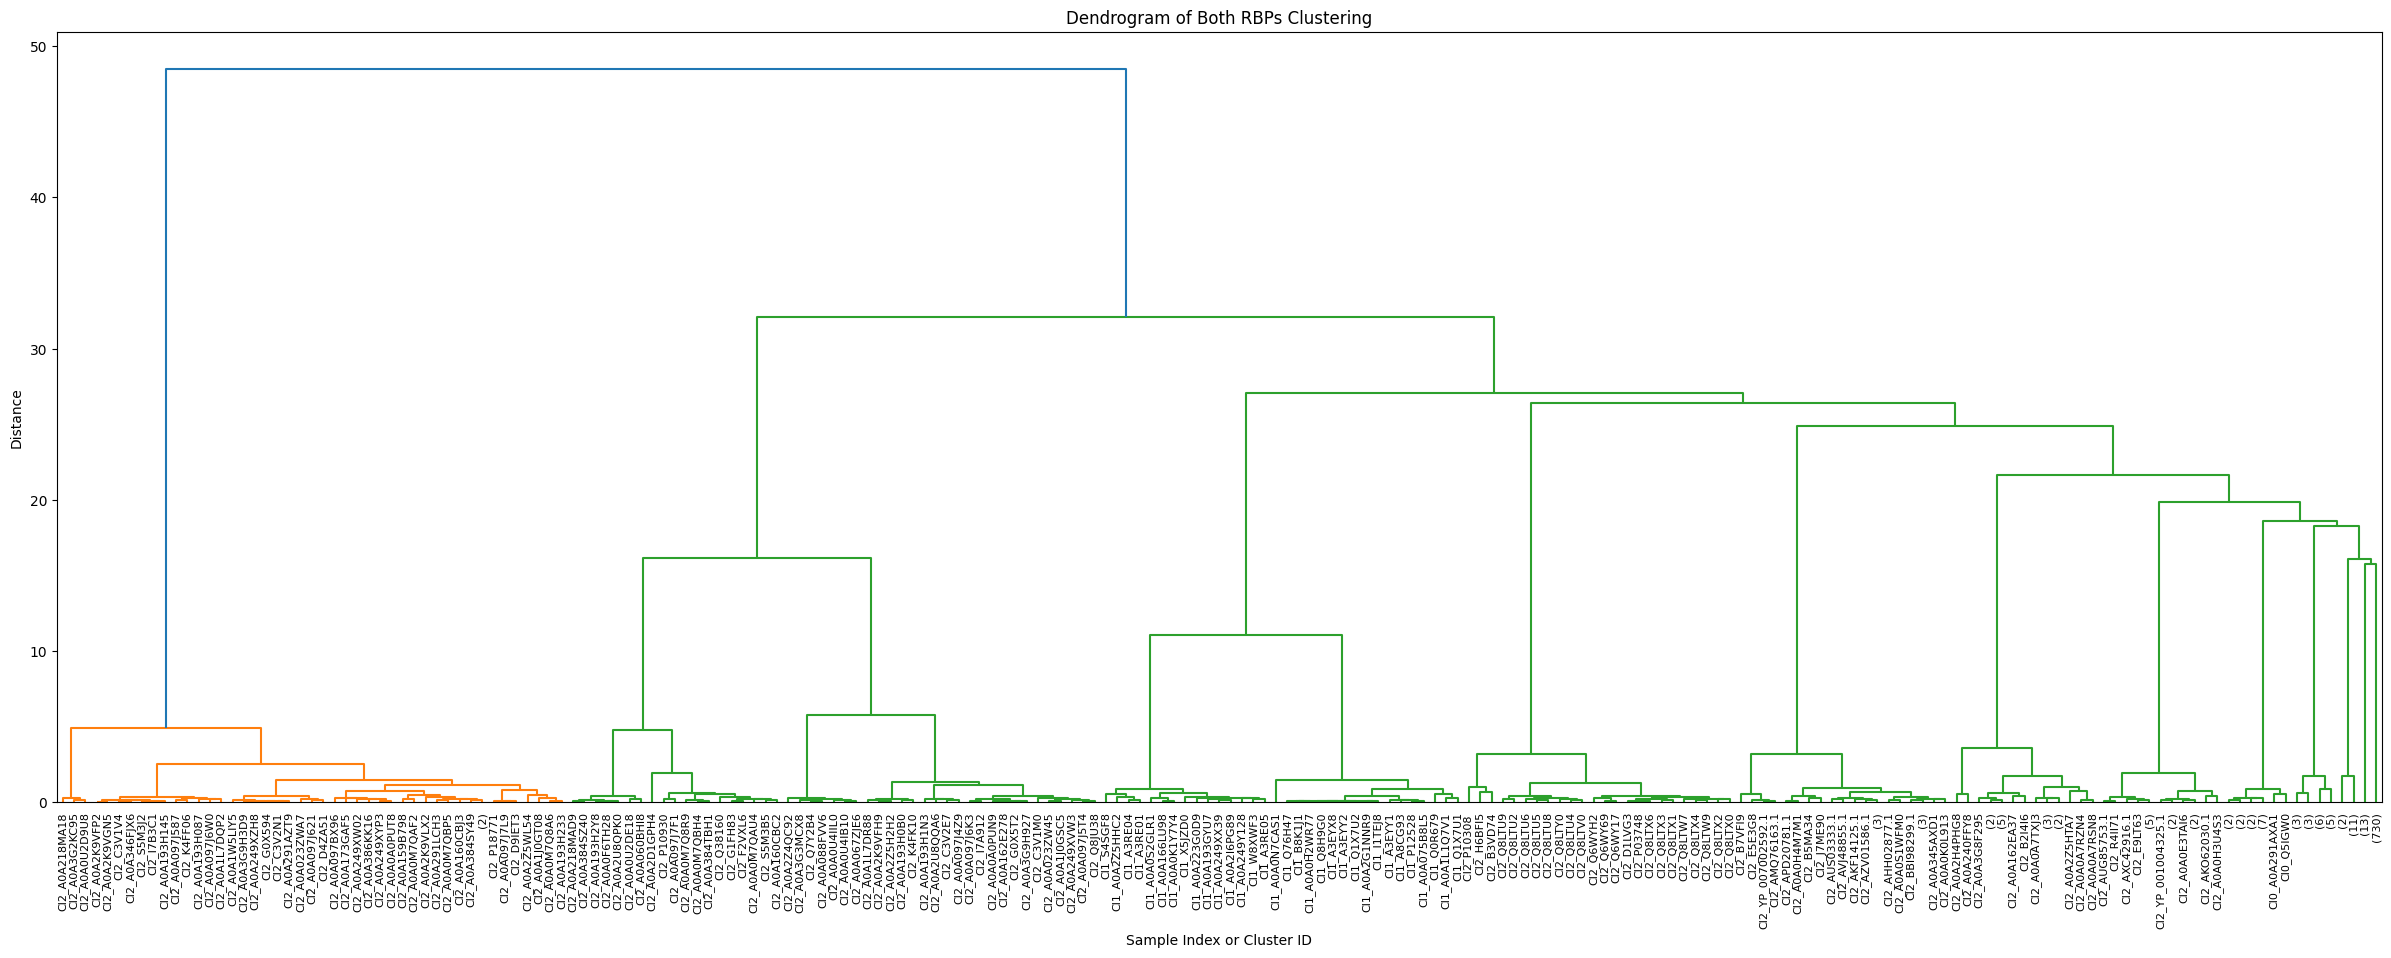


Saved results to 'rbp_clustered_results_unsupervised.xlsx'


In [67]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

# === Load dataset ===
df = pd.read_excel("phage_processed1.xlsx")

# === Vectorization ===
sequences = df["CleanSeq"].astype(str).tolist()
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 4))
X = vectorizer.fit_transform(sequences)

# === Find optimal k using silhouette score ===
print("Finding best k based on silhouette score...")
best_k = None
best_score = -1
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"k={k}, silhouette score={score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k
print(f"Best k = {best_k} with silhouette score = {best_score:.4f}")

# === Final clustering with best k ===
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
df['Cluster'] = kmeans.fit_predict(X)

# === PCA Visualization ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="Cluster", palette="tab10", s=60, edgecolor='k')
plt.title("PCA Projection of Both RBPs Colored by Cluster")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# === Dendrogram Visualization ===
distance_matrix = pairwise_distances(X.toarray(), metric='cosine')

Z = linkage(distance_matrix, method='ward')

plt.figure(figsize=(30, 10))
labels = df.apply(lambda row: f"Cl{row['Cluster']}_{row['RBP_Accession']}", axis=1).values
dendrogram(Z, labels=labels, truncate_mode='level', p=10, leaf_rotation=90)
plt.xticks(rotation=90, size=8)
plt.title('Dendrogram of Both RBPs Clustering')
plt.xlabel('Sample Index or Cluster ID')
plt.ylabel('Distance')
plt.show()


# === Save results ===
df.to_excel("rbp_clustered_results_unsupervised.xlsx", index=False)
print("\nSaved results to 'rbp_clustered_results_unsupervised.xlsx'")


In [65]:
best_score = -1
best_params = {}

for k in range(2, 10):
    for init_method in ['k-means++', 'random']:
        model = KMeans(n_clusters=k, init=init_method, random_state=42, n_init='auto')
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_params = {'n_clusters': k, 'init': init_method}

print(f"Best params: {best_params} with silhouette score: {best_score:.4f}")

Best params: {'n_clusters': 9, 'init': 'random'} with silhouette score: 0.0774


------------------------------------------------------------------------------------------------------------------

Final workflow k-means - NONVALIDATED:
- Clusters assigned to each sequence for 3 and 4 clusters
- Majority-vote mapping of clusters → morphotype
- Predicted morphotypes for each sequence based on cluster
- Classification reports showing precision, recall, f1-score
- Excel file with all info saved

Finding optimal number of clusters by silhouette score...
k=2, silhouette score=0.0163
k=3, silhouette score=0.0252
k=4, silhouette score=0.0324
k=5, silhouette score=0.0393

Best k=5 with silhouette score=0.0393
Best number of clusters: 5 with silhouette score: 0.0393


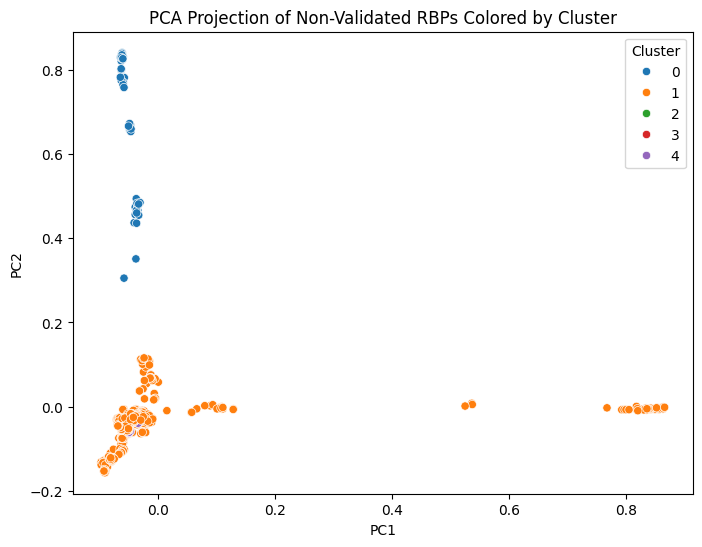

C:\Users\catia\AppData\Local\Temp\ipykernel_20944\2559677885.py:60: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


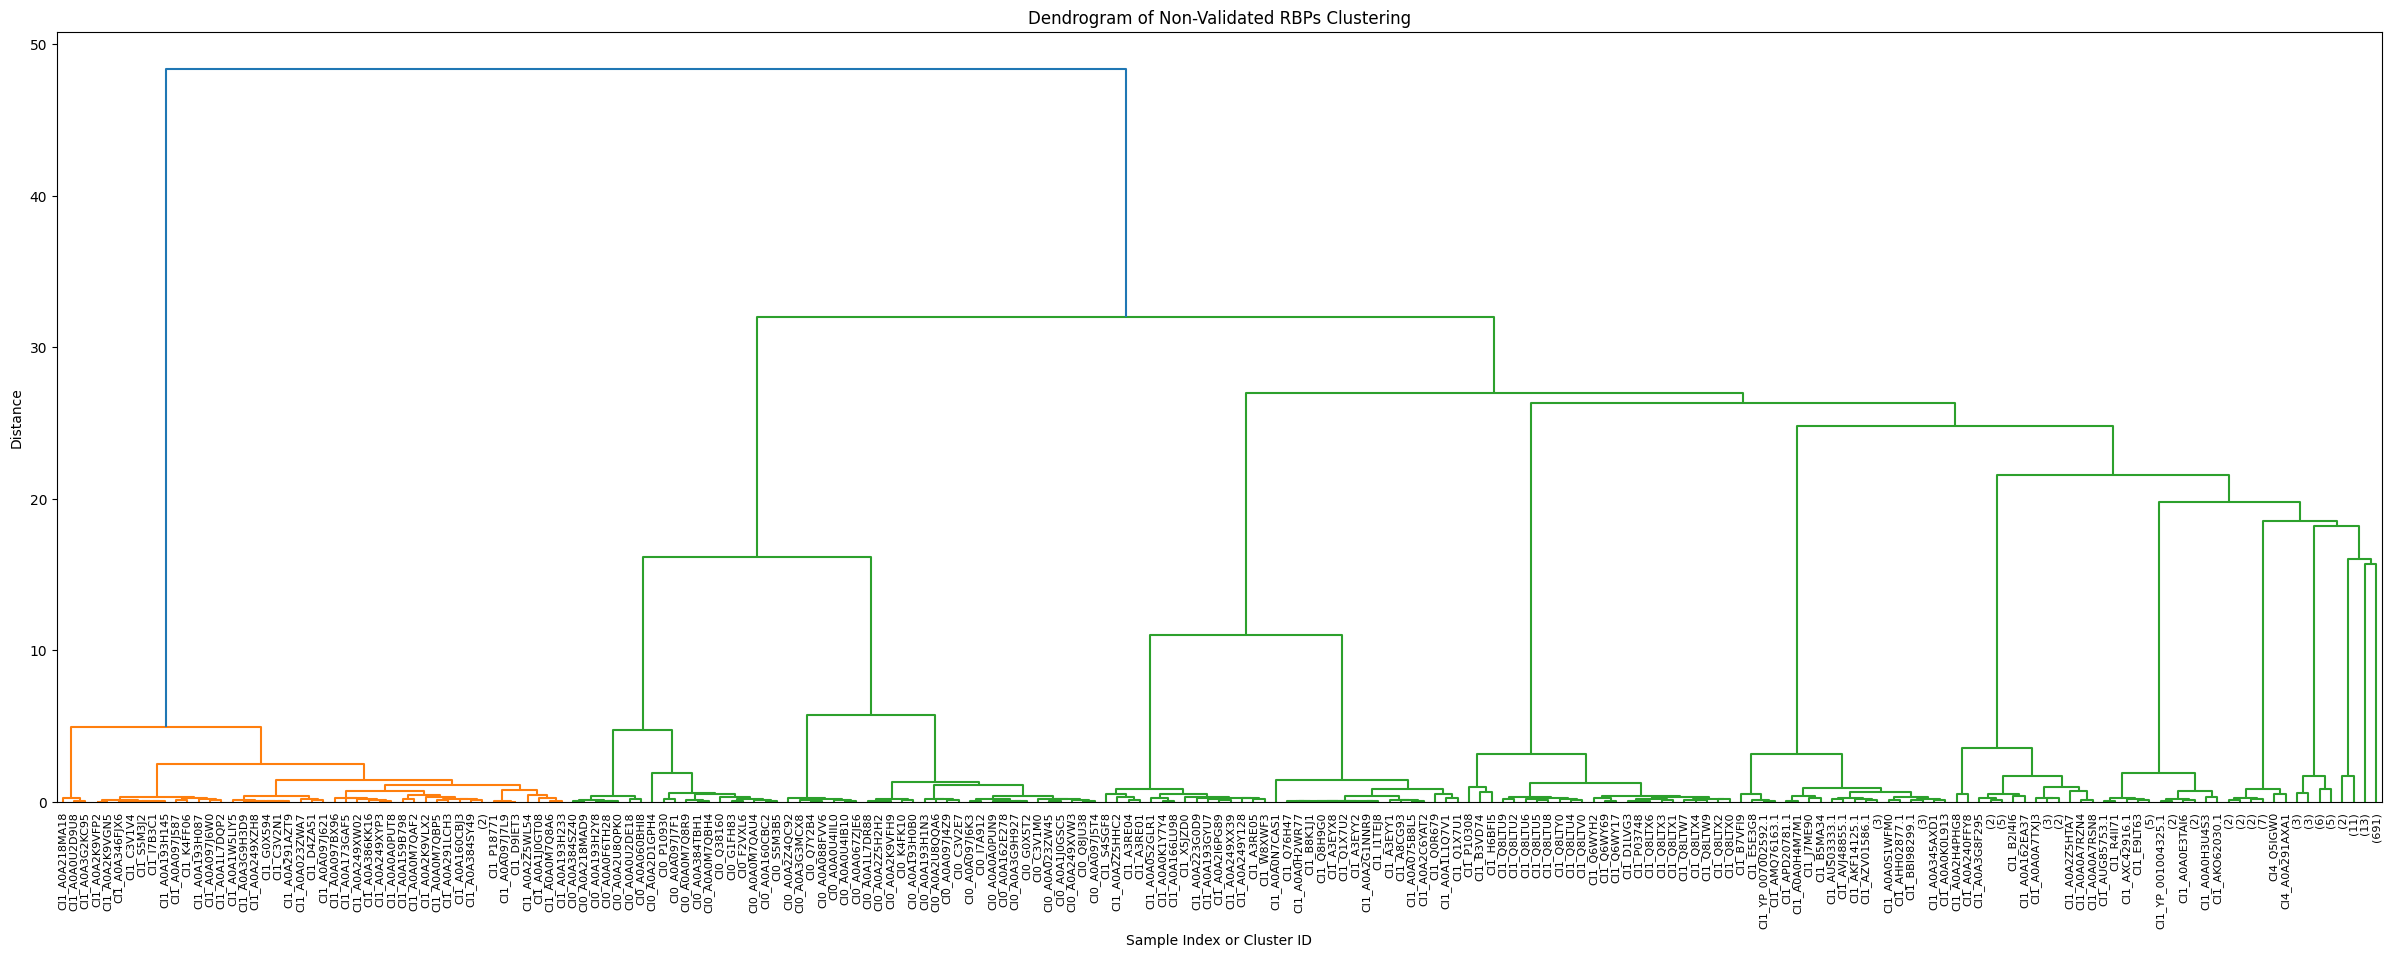

Saved clustering results to rbp_clustered_results_onlyNV.xlsx


In [68]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage

# === Load data ===
df = pd.read_excel("phage_processed2.xlsx")
sequences = df["RBP sequence (aa)"].astype(str).tolist()

# === Vectorize sequences using TF-IDF of 3-4-mers ===
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 4))
X = vectorizer.fit_transform(sequences)

# === Best number of clusters by Silhouette score ===
print("Finding optimal number of clusters by silhouette score...")

best_k = None
best_score = -1
scores = []

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)
    print(f"k={k}, silhouette score={score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nBest k={best_k} with silhouette score={best_score:.4f}")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
df['Cluster'] = kmeans.fit_predict(X)

print(f"Best number of clusters: {best_k} with silhouette score: {best_score:.4f}")

best_model = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
df['Cluster'] = best_model.fit_predict(X)

# === PCA ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='tab10', legend='full')
plt.title('PCA Projection of Non-Validated RBPs Colored by Cluster')
plt.show()

# === Dendrogram Visualization ===
distance_matrix = pairwise_distances(X.toarray(), metric='cosine')

Z = linkage(distance_matrix, method='ward')

plt.figure(figsize=(30, 10))
labels = df.apply(lambda row: f"Cl{row['Cluster']}_{row['RBP accession nr']}", axis=1).values
dendrogram(Z, labels=labels, truncate_mode='level', p=10, leaf_rotation=90)
plt.xticks(rotation=90, size=8)
plt.title('Dendrogram of Non-Validated RBPs Clustering')
plt.xlabel('Sample Index or Cluster ID')
plt.ylabel('Distance')
plt.show()

# === Save results ===
df.to_excel("rbp_clustered_results_onlyNV.xlsx", index=False)
print("Saved clustering results to rbp_clustered_results_onlyNV.xlsx")


In [62]:
best_score = -1
best_params = {}

for k in range(2, 10):
    for init_method in ['k-means++', 'random']:
        model = KMeans(n_clusters=k, init=init_method, random_state=42, n_init='auto')
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_params = {'n_clusters': k, 'init': init_method}

print(f"Best params: {best_params} with silhouette score: {best_score:.4f}")


Best params: {'n_clusters': 9, 'init': 'random'} with silhouette score: 0.0810
